In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
ratings = pd.DataFrame([[1,2,8,9,3,3],[2,1,9,8,4,2],[2,2,6,8,2,3],[9,7,2,3,1,1],
                   [1,1,1,2,8,7],[2,2,3,2,8,8],[7,9,2,2,2,3],[9,8,2,3,1,3]])

users = np.array(["u0","u1","u2","u3","u4","u5","u6","u7"])
movies = np.array(["horror1","horror2","drama1","drama2","art1","art2"])

ratings.columns = movies
ratings.index = users

In [3]:
ratings

,horror1,horror2,drama1,drama2,art1,art2
u0,1,2,8,9,3,3
u1,2,1,9,8,4,2
u2,2,2,6,8,2,3
u3,9,7,2,3,1,1
u4,1,1,1,2,8,7
u5,2,2,3,2,8,8
u6,7,9,2,2,2,3
u7,9,8,2,3,1,3


It is possible some users are more critical in rating movies than others and so we normalize/center the data.

In [4]:
mean_ratings = ratings.mean(axis=1).to_dict()
mean_ratings

{'u0': 4.333333333333333,
 'u1': 4.333333333333333,
 'u2': 3.8333333333333335,
 'u3': 3.8333333333333335,
 'u4': 3.3333333333333335,
 'u5': 4.166666666666667,
 'u6': 4.166666666666667,
 'u7': 4.333333333333333}

In [5]:
df = pd.DataFrame(ratings.values - ratings.mean(axis=1).values.reshape(-1,1)).round(2)

df.columns = ["horror1","horror2","drama1","drama2","art1","art2"]
df.index = ["u0","u1","u2","u3","u4","u5","u6","u7"]

df

,horror1,horror2,drama1,drama2,art1,art2
u0,-3.33,-2.33,3.67,4.67,-1.33,-1.33
u1,-2.33,-3.33,4.67,3.67,-0.33,-2.33
u2,-1.83,-1.83,2.17,4.17,-1.83,-0.83
u3,5.17,3.17,-1.83,-0.83,-2.83,-2.83
u4,-2.33,-2.33,-2.33,-1.33,4.67,3.67
u5,-2.17,-2.17,-1.17,-2.17,3.83,3.83
u6,2.83,4.83,-2.17,-2.17,-2.17,-1.17
u7,4.67,3.67,-2.33,-1.33,-3.33,-1.33


### Matrix Factorization

#### Singular Value Decomposition

In [6]:
# when full_matrices = False, shapes of U, S and VT are (M,K) (K,) and (K,N) respectively
# K = min(M,N)

U, S, VT = np.linalg.svd(df.values, full_matrices=False)
U.shape, S.shape, VT.shape

((8, 6), (6,), (6, 6))

In [7]:
def rmse(true,predicted):
    return np.mean((true-predicted)**2)

**Low rank approximation of matrix**

In [8]:
K=min(df.shape)

RMSE={}
for k in range(1,K+1):

    ratings_approx = U[:,:k]@np.diag(S[:k])@VT[:k,:]

    RMSE[k] = rmse(df.values,ratings_approx)
    
RMSE

{1: 3.369538816123779,
 2: 0.2718879860581851,
 3: 0.13453619571450898,
 4: 0.029225230988009953,
 5: 1.3638797418935775e-06,
 6: 3.266954964664068e-30}

In [9]:
#calculating ratings based on two dimensions
k=2

pred_ratings = (ratings.mean(axis=1).values.reshape(-1,1) + U[:,:k]@np.diag(S[:k])@VT[:k,:]).round(2)
pred_ratings

array([[1.53, 1.52, 8.38, 8.61, 3.28, 2.68],
       [1.45, 1.44, 8.4 , 8.62, 3.36, 2.74],
       [2.1 , 2.05, 6.89, 7.12, 2.61, 2.25],
       [8.15, 7.83, 2.33, 2.73, 0.48, 1.49],
       [0.83, 1.18, 1.83, 1.22, 7.77, 7.15],
       [1.86, 2.18, 2.76, 2.2 , 8.28, 7.7 ],
       [8.09, 7.86, 1.88, 2.09, 2.09, 2.98],
       [8.7 , 8.41, 2.33, 2.66, 1.45, 2.45]])

**Mapping to lower dimensions (M,N) to (K,N)**

\begin{equation}
A \mapsto \Sigma_{k} U_{k}^{T} A
\end{equation}

In [10]:
k=2

A=df.values

V = np.transpose(np.diag(S[:k]) @ np.transpose(U[:,:k]) @ A)
V.shape

(6, 2)

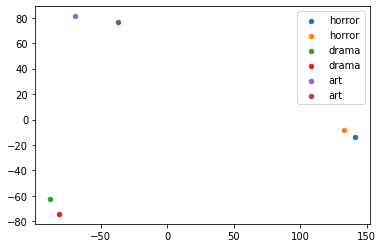

In [11]:
genres=['horror','horror','drama','drama','art','art']

for i in range(V.shape[0]):
    plt.scatter(label=genres[i], x=V[i][0], y=V[i][1], s=20)
    
plt.legend()
plt.show()

**We can notice that movies of different genres are far apart from each other and movies of same genres are close to each other.**

### Collaborative Filtering

In [12]:
#making predictions for (userid, movieid) pair
userid = 'u5'
movieid = 'drama1' 

df1 = df.copy()
df1.loc[userid, movieid]=None
df1

,horror1,horror2,drama1,drama2,art1,art2
u0,-3.33,-2.33,3.67,4.67,-1.33,-1.33
u1,-2.33,-3.33,4.67,3.67,-0.33,-2.33
u2,-1.83,-1.83,2.17,4.17,-1.83,-0.83
u3,5.17,3.17,-1.83,-0.83,-2.83,-2.83
u4,-2.33,-2.33,-2.33,-1.33,4.67,3.67
u5,-2.17,-2.17,NaN,-2.17,3.83,3.83
u6,2.83,4.83,-2.17,-2.17,-2.17,-1.17
u7,4.67,3.67,-2.33,-1.33,-3.33,-1.33


In [13]:
df1 = df1.dropna(axis='columns')
df1

,horror1,horror2,drama2,art1,art2
u0,-3.33,-2.33,4.67,-1.33,-1.33
u1,-2.33,-3.33,3.67,-0.33,-2.33
u2,-1.83,-1.83,4.17,-1.83,-0.83
u3,5.17,3.17,-0.83,-2.83,-2.83
u4,-2.33,-2.33,-1.33,4.67,3.67
u5,-2.17,-2.17,-2.17,3.83,3.83
u6,2.83,4.83,-2.17,-2.17,-1.17
u7,4.67,3.67,-1.33,-3.33,-1.33


In [14]:
def find_cosine_similarity(v1,v2):
    return np.dot(v1,v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [15]:
def find_cosine_similarity_dict(userid, df1):

    v1 = df1.loc[userid].values
    csim = {}

    for user in df1.index:

        if (user!=userid):
            v2 = df1.loc[user].values
            csim[user] = find_cosine_similarity(v1,v2)
            
    return csim

In [16]:
csim = find_cosine_similarity_dict(userid, df1)
csim

{'u0': -0.18846848573643268,
 'u1': -0.14937219947060032,
 'u2': -0.3230407133410321,
 'u3': -0.7876091452135945,
 'u4': 0.9848779179101157,
 'u6': -0.5773762616126623,
 'u7': -0.7098377347000132}

In [17]:
def make_prediction(df, userid, movieid, csim):

    num=0
    den=0

    for user in df.index:

        if (user!=userid):
            r = df.loc[user,movieid]
            c_similarity = csim[user]

            num += r * c_similarity
            den += c_similarity

    prediction = mean_ratings[userid] + num/den
    return prediction

In [18]:
prediction = make_prediction(df, userid, movieid, csim)
prediction

4.187718588714821

In [19]:
print('ACTUAL RATING: ', ratings.loc[userid, movieid])
print('PREDICTED RATING: ', prediction.round(2))

ACTUAL RATING:  3
PREDICTED RATING:  4.19


**Let's calculate accuracy of this method by running the method for a large number of examples**

In [20]:
def iteration(userid, movieid, df):
    
    df1 = df.copy()
    df1.loc[userid, movieid]=None
    df1 = df1.dropna(axis='columns')

    csim = find_cosine_similarity_dict(userid, df1)

    prediction = make_prediction(df, userid, movieid, csim)
    actual = ratings.loc[userid, movieid]
    error = abs(actual-prediction)
    
    return error

In [21]:
N_ITERATIONS = 1000

errors=[]

for _ in tqdm(range(N_ITERATIONS)):
    u = np.random.choice(users)
    m = np.random.choice(movies)

    error = iteration(u, m, df)
    errors.append(error)
    
errors = np.array(errors)
mae = np.mean(errors).round(2)
rmse = np.sqrt(np.mean(errors**2)).round(2)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 356.44it/s]


In [22]:
print('Mean Absolute Error (MAE): ', mae)
print('Root Mean Square Error (RMSE): ', rmse)

Mean Absolute Error (MAE):  31.29
Root Mean Square Error (RMSE):  73.73


**Similarly can be done for item-item collaborative filtering**